In [ ]:
import matplotlib.pyplot as plt
import sys
from absl import app

# Addresses `UnrecognizedFlagError: Unknown command line flag 'f'`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
  app.run(lambda argv: None)
except:
  pass
%pip install dm-haiku
%pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 2.1 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 


## qnn

In [ ]:
import functools
from functools import partial
import itertools
from typing import (Callable, List, Mapping, NamedTuple, Optional, Sequence,
                    Tuple, Union)

import jax
import numpy as np
from jax import lax
from jax import numpy as jnp

# Typing
# -----------------------------------------------------------------------------

Array = jnp.ndarray
Shape = Tuple[int, ...]
Dtype = Union[jnp.float32, jnp.float64]
PRNGKey = Array
Params = Mapping[str, Mapping[str, jnp.ndarray]]
InitializerFn = Callable[[PRNGKey, Shape, Dtype], Array]


class ModuleFn(NamedTuple):
    apply: Callable[..., Array]
    shape: Optional[Callable[[Shape], Shape]]
    init: Optional[Callable[..., Tuple[Params, Array]]] = None


def add_scope_to_params(scope, params):
    return dict((f"{scope}/{key}", array) for key, array in params.items())


def get_params_by_scope(scope, params):
    return dict((key[len(scope) + 1:], array) for key, array in params.items()
                if key.startswith(scope + '/'))


# Initializers
# -----------------------------------------------------------------------------


def constant(val: float, ) -> InitializerFn:
    def init_fn(key, shape, dtype=jnp.float32):
        return jnp.broadcast_to(val, shape).astype(dtype)

    return init_fn


def zeros() -> InitializerFn:
    """ Initialize with zeros."""
    return constant(0.)


def ones() -> InitializerFn:
    """ Initialize with ones."""
    return constant(1.)


def uniform(
    minval: float = 0.,
    maxval: float = 1.,
) -> InitializerFn:
    def init_fn(key, shape, dtype=jnp.float32):
        return jax.random.uniform(key, shape, dtype, minval, maxval)

    return init_fn


def normal(
    mean: float = 0.,
    std: float = 1.,
) -> InitializerFn:
    def init_fn(key, shape, dtype=jnp.float32):
        _mean = lax.convert_element_type(mean, dtype)
        _std = lax.convert_element_type(std, dtype)
        return _mean + _std * jax.random.normal(key, shape, dtype)

    return init_fn


def truncated_normal(
    mean: float = 0.,
    std: float = 1.,
) -> InitializerFn:
    def init_fn(key, shape, dtype=jnp.float32):
        _mean = lax.convert_element_type(mean, dtype)
        _std = lax.convert_element_type(std, dtype)
        return _mean + _std * jax.random.truncated_normal(
            key, -2., 2., shape, dtype)

    return init_fn


# Activations
# -----------------------------------------------------------------------------


def activation(activation_fn: Callable[[Array], Array], ) -> ModuleFn:
    def shape_fn(inputs_shape):
        return inputs_shape

    def apply_fn(params, key, inputs, **kwargs):
        return activation_fn(inputs)

    return ModuleFn(apply_fn, shape_fn)


relu = activation(jax.nn.relu)
gelu = activation(jax.nn.gelu)
selu = activation(jax.nn.selu)
tanh = activation(jax.nn.tanh)
square = activation(jnp.square)
sigmoid = activation(jax.nn.sigmoid)
log_softmax = activation(jax.nn.log_softmax)
softmax = activation(jax.nn.softmax)


def linear(
    n_features: int,
    with_bias: bool = True,
) -> ModuleFn:
    def apply_fn(params, key, inputs, **kwargs):
        outputs = jnp.dot(inputs, params['w'])
        if with_bias:
            outputs += params['b']
        return outputs

    def init_fn(key, inputs_shape):
        params = {}
        key, w_key, b_key = jax.random.split(key, 3)
        w_init = truncated_normal(std=1. / inputs_shape[-1])
        w_shape = (inputs_shape[-1], n_features)
        params['w'] = w_init(w_key, w_shape)
        if with_bias:
            b_init = zeros()
            b_shape = (n_features, )
            params['b'] = b_init(b_key, b_shape)
        return params

    def shape_fn(inputs_shape):
        shape = inputs_shape[:-1] + (n_features, )
        return shape

    return ModuleFn(apply_fn, shape_fn, init=init_fn)


def flatten() -> ModuleFn:
    def apply_fn(params, key, inputs, **kwargs):
        return jnp.reshape(inputs, (inputs.shape[0], -1))

    def shape_fn(inputs_shape):
        return (inputs_shape[0], np.prod(inputs_shape[1:]))

    return ModuleFn(apply_fn, shape_fn)


def sequential(*modules: List[ModuleFn], ) -> ModuleFn:
    def apply_fn(params, key, inputs, **kwargs):
        outputs = inputs
        if key is not None:
            keys = jax.random.split(key, len(modules))
        else:
            keys = len(modules) * [None]
        for idx, module in enumerate(modules):
            outputs = module.apply(
                params['layer_{}'.format(idx)],
                keys[idx],
                outputs,
                **kwargs,
            )
        return outputs

    def init_fn(key, inputs_shape):
        params = dict(
            ('layer_{}'.format(idx), None) for idx in range(len(modules)))
        keys = jax.random.split(key, len(modules))
        shape = inputs_shape
        for idx, module in enumerate(modules):
            if module.init is not None:
                module_params = module.init(keys[idx], shape)
                params['layer_{}'.format(idx)] = module_params
            shape = module.shape(shape)
        return params

    def shape_fn(inputs_shape):
        shape = inputs_shape
        for module in modules:
            shape = module.shape(shape)
        return shape

    return ModuleFn(apply_fn, shape_fn, init=init_fn)


def _make_orthogonal_fn(rbs_idxs, size):
    num_thetas = sum(map(len, rbs_idxs))
    rbs_idxs = [list(map(list, rbs_idx)) for rbs_idx in rbs_idxs]
    len_idxs = np.cumsum([0] + list(map(len, rbs_idxs)))

    def _get_rbs_unitary(theta):
        cos_theta, sin_theta = jnp.cos(theta), jnp.sin(theta)
        unitary = jnp.array([
            [cos_theta, -sin_theta],
            [sin_theta, cos_theta],
        ])
        unitary = unitary.transpose(*[*range(2, unitary.ndim), 0, 1])
        return unitary

    def _get_rbs_unitary_grad(theta):
        cos_theta, sin_theta = jnp.cos(theta), jnp.sin(theta)
        unitary = jnp.array([
            [-sin_theta, -cos_theta],
            [cos_theta, -sin_theta],
        ])
        unitary = unitary.transpose(*[*range(2, unitary.ndim), 0, 1])
        return unitary

    @jax.custom_jvp
    def _get_parallel_rbs_unitary(thetas):
        unitaries = []
        for i, idxs in enumerate(rbs_idxs):
            idxs = sum(idxs, [])
            sub_thetas = thetas[len_idxs[i]:len_idxs[i + 1]]
            rbs_blocks = _get_rbs_unitary(sub_thetas)
            eye_block = jnp.eye(size - len(idxs), dtype=thetas.dtype)
            permutation = idxs + [i for i in range(size) if i not in idxs]
            permutation = np.argsort(permutation)
            unitary = jax.scipy.linalg.block_diag(*rbs_blocks, eye_block)
            unitary = unitary[permutation][:, permutation]
            unitaries.append(unitary)
        unitaries = jnp.stack(unitaries)
        return unitaries

    @_get_parallel_rbs_unitary.defjvp
    def get_parallel_rbs_unitary_jvp(primals, tangents):
        thetas, = primals
        thetas_dot, = tangents
        unitaries = []
        unitaries_dot = []
        for i, idxs in enumerate(rbs_idxs):
            idxs = sum(idxs, [])
            sub_thetas = thetas[len_idxs[i]:len_idxs[i + 1]]
            sub_thetas_dot = thetas_dot[len_idxs[i]:len_idxs[i + 1]]
            rbs_blocks = _get_rbs_unitary(sub_thetas)
            rbs_blocks_grad = _get_rbs_unitary_grad(sub_thetas)
            rbs_blocks_dot = sub_thetas_dot[..., None, None] * rbs_blocks_grad
            eye_block = jnp.eye(size - len(idxs), dtype=thetas.dtype)
            zero_block = jnp.zeros_like(eye_block)
            permutation = idxs + [i for i in range(size) if i not in idxs]
            permutation = np.argsort(permutation)
            unitary = jax.scipy.linalg.block_diag(*rbs_blocks, eye_block)
            unitary_dot = jax.scipy.linalg.block_diag(*rbs_blocks_dot,
                                                      zero_block)
            unitary = unitary[permutation][:, permutation]
            unitary_dot = unitary_dot[permutation][:, permutation]
            unitaries.append(unitary)
            unitaries_dot.append(unitary_dot)
        primal_out = jnp.stack(unitaries)
        tangent_out = jnp.stack(unitaries_dot)
        return primal_out, tangent_out

    def orthogonal_fn(thetas, precision=None):
        assert thetas.shape[0] == num_thetas, "Wrong number of thetas."
        unitaries = _get_parallel_rbs_unitary(thetas)
        unitary = jnp.linalg.multi_dot(unitaries[::-1], precision=precision)
        return unitary

    return orthogonal_fn


def _get_pyramid_idxs(num_inputs, num_outputs):
    num_max = max(num_inputs, num_outputs)
    num_min = min(num_inputs, num_outputs)
    if num_max == num_min:
        num_min -= 1
    end_idxs = np.concatenate(
        [np.arange(1, num_max - 1), num_max - np.arange(1, num_min + 1)])
    start_idxs = np.concatenate([
        np.arange(end_idxs.shape[0] + num_min - num_max) % 2,
        np.arange(num_max - num_min)
    ])
    if num_inputs < num_outputs:
        start_idxs = start_idxs[::-1]
        end_idxs = end_idxs[::-1]
    rbs_idxs = [
        np.arange(start_idxs[i], end_idxs[i] + 1).reshape(-1, 2)
        for i in range(len(start_idxs))
    ]
    return rbs_idxs


def _get_butterfly_idxs(num_inputs, num_outputs):
    def _get_butterfly_idxs(n):
        if n == 2:
            return np.array([[[0, 1]]])
        else:
            rbs_idxs = _get_butterfly_idxs(n // 2)
            first = np.concatenate([rbs_idxs, rbs_idxs + n // 2], 1)
            last = np.arange(n).reshape(1, 2, n // 2).transpose(0, 2, 1)
            rbs_idxs = np.concatenate([first, last], 0)
            return rbs_idxs

    circuit_dim = int(2**np.ceil(np.log2(max(num_inputs, num_outputs))))
    rbs_idxs = _get_butterfly_idxs(circuit_dim)
    if num_inputs < num_outputs:
        rbs_idxs = rbs_idxs[::-1]
    return rbs_idxs


def _get_triangle_idxs(num_inputs, num_outputs):
    num_max = max(num_inputs, num_outputs)
    num_min = min(num_inputs, num_outputs)
    rbs_idxs = [[(i, i + 1)] for i in range(num_max - 1)
                ] + [[(num_max - num_min + i, num_max - num_min + i + 1)]
                     for i in range(num_min - 1 - 1)][::-1]
    if num_inputs < num_outputs:
        rbs_idxs = rbs_idxs[::-1]
    return rbs_idxs


def _get_iks_idxs(num_inputs, num_outputs):
    num_max = max(num_inputs, num_outputs)
    num_min = min(num_inputs, num_outputs)
    rbs_idxs_down = [[(i, i + 1)] for i in range(num_max - 1)]
    rbs_idxs_up = [[(num_max - num_min + i, num_max - num_min + i + 1)]
                   for i in range(num_min - 1)][::-1]
    rbs_idxs = [
        (m + n if m != n else m) for m, n in zip(rbs_idxs_down, rbs_idxs_up)
    ] + rbs_idxs_down[num_min - 1:]
    if num_inputs < num_outputs:
        rbs_idxs = rbs_idxs[::-1]
    return rbs_idxs

def _multi_kron(arrays, order, i, j):
    if i == j:
        return arrays[i]
    else:
        return jnp.kron(_multi_kron(arrays, order, i, order[i, j]),
                        _multi_kron(arrays, order, order[i, j] + 1, j))


def _tensordot_unitary(unitaries):
    from jax._src.third_party.numpy.linalg import _multi_dot_matrix_chain_order
    if len(unitaries) == 1:
        unitary = unitaries[0]
    elif len(unitaries) == 2:
        unitary = jnp.kron(unitaries[0], unitaries[1])
    else:
        order = _multi_dot_matrix_chain_order(unitaries)
        unitary = _multi_kron(unitaries, order, 0, len(unitaries) - 1)
    return unitary

def _make_general_orthogonal_fn(rbs_idxs, size):
    num_thetas = sum(map(len, rbs_idxs))
    rbs_idxs = [list(map(list, rbs_idx)) for rbs_idx in rbs_idxs]
    len_idxs = np.cumsum([0] + list(map(len, rbs_idxs)))

    def _get_rbs_unitary(theta):
        """ Returns the unitary matrix for a single RBS gate. """
        cos_t, sin_t = jnp.cos(theta), jnp.sin(theta)
        zeros = jnp.zeros_like(cos_t)
        ones = jnp.ones_like(cos_t)
        unitary = jnp.array([
            [ones, zeros, zeros, zeros],
            [zeros, cos_t, -sin_t, zeros],
            [zeros, sin_t, cos_t, zeros],
            [zeros, zeros, zeros, ones],
        ])
        unitary = unitary.transpose(*[*range(2, unitary.ndim), 0, 1])
        return unitary

    def _get_parallel_rbs_unitary(thetas):
        """ Returns the unitary matrix for parallel RBS gates. """
        unitaries = []
        num_qubits = size
        map_qubits = [[0, 2**q] for q in range(num_qubits)]
        for i, idxs in enumerate(rbs_idxs):
            idxs = sum(idxs, [])
            sub_thetas = thetas[len_idxs[i]:len_idxs[i + 1]]
            rbs_blocks = _get_rbs_unitary(sub_thetas)
            eye_block = jnp.eye(2**(size - len(idxs)), dtype=thetas.dtype)
            unitary = _tensordot_unitary([*rbs_blocks, eye_block])
            unitary_qubits = idxs + [
                q for q in range(num_qubits) if q not in idxs
            ]
            permutation = np.argsort([
                sum(binary)
                for binary in itertools.product(*(map_qubits[q]
                                                  for q in unitary_qubits))
            ])
            unitary = unitary[permutation][:, permutation]
            unitaries.append(unitary)
        unitaries = jnp.stack(unitaries)

        return unitaries

    def orthogonal_fn(thetas, precision=None):
        """ Returns the unitary matrix for a sequence of parallel RBS gates. """
        assert thetas.shape[0] == num_thetas, "Wrong number of thetas."
        unitaries = _get_parallel_rbs_unitary(thetas)
        unitary = jnp.linalg.multi_dot(unitaries[::-1], precision=precision)
        return unitary

    return orthogonal_fn
    

def rbs_fn(num_qubits):
  rbs_idxs = _get_butterfly_idxs(num_qubits,num_qubits)
  rbs_idxs = [list(map(list, rbs_idx)) for rbs_idx in rbs_idxs]
  num_params = len(sum(rbs_idxs, []))
  return rbs_idxs, num_params

## Main

In [ ]:
import haiku as hk 
from functools import partial
def circuit_v0(seq_jumps):
    num_days = seq_jumps.shape[-2]
    
    @jax.vmap 
    def encode(seq_jumps):
        num_days, num_jumps = seq_jumps.shape
        encodings = []
        for time_step in range(num_days):
            future_qubits = (num_days - time_step) * num_jumps
            future = 1/np.sqrt(2**future_qubits) * jnp.ones((2**future_qubits,))
            if time_step == 0:
                encoding = future
            else:
                aux = seq_jumps[time_step].reshape(-1)
                aux = jnp.concatenate((1-aux,aux),0)
                if time_step ==1:
                    past = aux 
                else:
                    past = jnp.kron(past, aux)
                encoding = jnp.kron(past, future)
            encoding = jnp.kron(encoding, jnp.array([0.,1.,0.,0.]))
            encodings.append(encoding)
        encodings = jnp.stack(encodings,0)
        return encodings
    
    def apply(seq_encodings):
        rbs_idxs, num_params = rbs_fn(num_days+2)
        seq_thetas = hk.get_parameter("thetas", 
                                    shape=[num_days,num_params],
                                    dtype=jnp.float32,
                                    init=hk.initializers.RandomNormal(stddev=1.0/np.sqrt(len(rbs_idxs)), mean=0.0))
        orthogonal_fn = _make_general_orthogonal_fn(rbs_idxs=rbs_idxs,size=num_days+2)
        seq_unitaries = jax.vmap(orthogonal_fn)(seq_thetas)
        seq_results = jnp.einsum("...tij,...tj->...ti",seq_unitaries,seq_encodings)
        seq_probs = jnp.abs(seq_results)**2
        return seq_probs 

    supports = []
    bits = list(itertools.product(*((num_days+2)*[(0,1)]))) 
    for time_step in range(num_days):
        observables = []
        for weight in range(time_step+1):
            observable = jnp.zeros((2**(num_days+2),),dtype=jnp.float32)
            for subspace in range(weight+1, (num_days-time_step+weight+1)+1):
                permutations = [bit for bit in bits if sum(bit)==subspace]
                idxs = jnp.array(permutations) @ 2**jnp.arange(num_days+2)
                values = jnp.arange(len(idxs))/(len(idxs) - 1) 
                observable = observable.at[idxs].set(values)
            observables.append(observable)
        observables = jnp.stack(observables)
        supports.append(observables)
        
    @jax.vmap
    def project(seq_jumps):
        seq_obs = []
        for time_step in range(num_days):
            if time_step == 0:
                observable = supports[0]
            else:
                idx = seq_jumps[:time_step,0].sum()
                observable = jax.lax.dynamic_index_in_dim(supports[time_step],jnp.int32(idx),0)
            seq_obs.append(observable)
        seq_obs = jnp.concatenate(seq_obs)
        return seq_obs
    
    seq_encodings = encode(seq_jumps)
    seq_probs = apply(seq_encodings)
    seq_obs = project(seq_jumps)
    seq_vals = jnp.einsum("...t,...t->...",seq_probs,seq_obs)
    return seq_vals

In [ ]:
import collections
import sys

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from absl import app, flags
from tqdm import trange
from scipy import stats
import itertools 

def jumps_to_prices(jumps):
    jumps = jumps.reshape(jumps.shape[0], FLAGS.num_days * FLAGS.num_jumps)
    brownian = (jumps - FLAGS.bernoulli_p)  # mean 0
    brownian /= np.sqrt(FLAGS.bernoulli_p *
                        (1 - FLAGS.bernoulli_p))  # variance 1
    brownian = jnp.cumsum(brownian, axis=1)  # cumulative sum
    brownian /= np.sqrt(FLAGS.num_jumps * FLAGS.num_trading_days )  # standardize
    brownian = brownian[:, FLAGS.num_jumps * np.arange(FLAGS.num_days)]
    t = jnp.arange(1, 1 + FLAGS.num_days) / FLAGS.num_trading_days
    log_prices = (FLAGS.mu - FLAGS.sigma**2/2) * t +  FLAGS.sigma * brownian
    prices = jnp.exp(log_prices)
    prices = jnp.concatenate((jnp.ones((prices.shape[0], 1)), prices), axis=1)
    prices *= FLAGS.initial_price
    return prices[..., None]

def prices_to_BSdeltas(seq_prices):
  seq_prices = seq_prices[:,:-1]
  T = jnp.arange(1, FLAGS.num_days+1) / FLAGS.num_trading_days
  T = jnp.repeat(jnp.flip(T[None,:]), seq_prices.shape[0],0)
  d1 = jnp.divide(jnp.log(seq_prices[...,0]/FLAGS.strike_price)+ (FLAGS.mu + 0.5 * FLAGS.sigma **2)* T, FLAGS.sigma * jnp.sqrt(T))
  seq_bs_deltas = (stats.norm.cdf(d1, 0.0, 1.0))[...,None]
  seq_deltas = seq_bs_deltas
  seq_actions = jnp.concatenate(
            [seq_deltas[:, [0]], seq_deltas[:, 1:] - seq_deltas[:, :-1]],
            axis=1) 
  return seq_deltas, seq_actions

def build_actor_fn():
    def actor_fn(seq_jumps):
        seq_deltas = []
        seq_prices = jumps_to_prices(seq_jumps)
        for time_step in range(FLAGS.num_days):
            features = seq_prices[:, :time_step]
            features = features.reshape(features.shape[0], -1)
            net = hk.nets.MLP(FLAGS.hidden_layers*[ FLAGS.hidden_units]+ [1])
            deltas = 0.5 * (1 + jax.nn.tanh(net(features)))
            seq_deltas.append(deltas)
        seq_deltas = jnp.stack(seq_deltas, axis=1)
        seq_actions = jnp.concatenate(
            [seq_deltas[:, [0]], seq_deltas[:, 1:] - seq_deltas[:, :-1]],
            axis=1)
        return seq_deltas, seq_actions

    return actor_fn

def build_actor_quantum_fn():
    def actor_fn(seq_jumps):
        seq_deltas = circuit_v0(seq_jumps)
        seq_deltas = seq_deltas[...,None]
        seq_actions = jnp.concatenate(
            [seq_deltas[:, [0]], seq_deltas[:, 1:] - seq_deltas[:, :-1]],
            axis=1)
        return seq_deltas, seq_actions

    return actor_fn

def build_critic_fn(activation_fn=None):
    def critic_fn(seq_jumps, seq_deltas):
        seq_values = []
        seq_prices = jumps_to_prices(seq_jumps)
        for time_step in range(FLAGS.num_days):
            features = seq_prices[:, :time_step]
            features = features.reshape(features.shape[0], -1)
            net = hk.nets.MLP([FLAGS.hidden_units, FLAGS.hidden_units, 1])
            if activation_fn:
              values = activation_fn(net(features))
            else:
              values = net(features)
            seq_values.append(values)
        seq_values = jnp.stack(seq_values, axis=1)
        return seq_values

    return critic_fn

def build_critic_quantum_fn():
    def critic_fn(seq_jumps, seq_deltas):
      seq_values = circuit_v0(seq_jumps)
      seq_values = seq_values[...,None]
      return seq_values
    return critic_fn


In [ ]:
def dh_vanilla(model):
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  if model == 'classical':
      actor_fn = build_actor_fn()
  elif model == 'quantum':
      actor_fn = build_actor_quantum_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.radam(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  def actor_loss_fn(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = -jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      loss = -(seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean()))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, actor_state, key, seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss
  def eval_step(actor_params, key, seq_jumps):
        shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
        seq_jumps = jax.random.bernoulli(jax.random.PRNGKey(123),
                                        shape=shape,
                                        p=FLAGS.bernoulli_p)
        seq_prices = jumps_to_prices(seq_jumps)
        seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
        seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                        seq_actions) * seq_prices[:, :-1]
        seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
        final_actions = -seq_deltas[:, -1]
        final_rewards = -jnp.maximum(
            seq_prices[:, -1] - FLAGS.strike_price,
            0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                  final_actions) * seq_prices[:, -1]
        seq_returns += final_rewards
        eval_returns = seq_rewards[0, 0] - jnp.log(
            1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
        return eval_returns
  def eval_BS(seq_jumps):
    seq_prices = jumps_to_prices(seq_jumps)
    seq_deltas,seq_actions = prices_to_BSdeltas(seq_prices)
    seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                        seq_actions) * seq_prices[:, :-1]
    seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
    final_actions = -seq_deltas[:, -1]
    final_rewards = jnp.maximum(
        seq_prices[:, -1] - FLAGS.strike_price,
        0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
              final_actions) * seq_prices[:, -1]
    seq_returns += final_rewards
    eval_returns = seq_rewards[0, 0] - jnp.log(
        1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
    return eval_returns

  plot_info = {}
  plot_info['actor_loss'] = []
  plot_info['utility'] = []
  plot_info['BS utility'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Train Actor
          shape = (FLAGS.num_actor_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, actor_state, next(rng_key), seq_jumps)
          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          BS_returns = eval_BS(seq_jumps)
          plot_info['actor_loss'].append(actor_loss)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['BS utility'].append(BS_returns.mean())
          t.set_postfix(utility=eval_returns.mean(),BS_utility=BS_returns.mean(),actor_loss=actor_loss)
  return plot_info


In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 4, "Number of days per episode.")
flags.DEFINE_integer("num_trading_days", 251, "Number of trading days in year.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 16, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")
dh_quantum_vanilla_4_info = dh_vanilla(model='quantum')

100%|██████████| 500/500 [04:35<00:00,  1.81it/s, BS_utility=-47.854233, actor_loss=4.77028, utility=-4.717611]


In [ ]:
dh_classical_vanilla_4_info['utility'][-1]

DeviceArray(-2.4091146, dtype=float32)

In [ ]:
plt.title('4 days no transaction costs')
plt.xlabel('Steps')
plt.ylabel('Utility')
plt.plot(dh_classical_vanilla_4_info['utility'], label='classical')
plt.plot(dh_quantum_vanilla_4_info['utility'],color='green', label='quantum')
plt.grid()
plt.legend()
plt.savefig('policy_search_4.png', dpi=300)

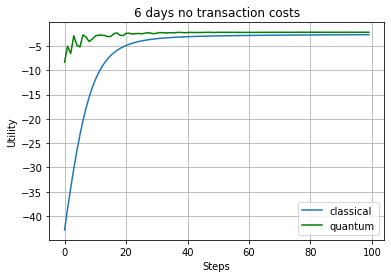

In [ ]:
plt.title('6 days no transaction costs')
plt.xlabel('Steps')
plt.ylabel('Utility')
plt.plot(dh_classical_vanilla_6_info['utility'], label='classical')
plt.plot(dh_quantum_vanilla_6_info['utility'],color='green', label='quantum')
plt.grid()
plt.legend()
plt.savefig('policy_search_6.png', dpi=300)

In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 6, "Number of days per episode.")
flags.DEFINE_integer("num_trading_days", 251, "Number of trading days in year.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 1, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 16, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")

In [ ]:
rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
shape = (FLAGS.num_actor_episodes, FLAGS.num_days, FLAGS.num_jumps)
seq_jumps = jax.random.bernoulli(next(rng_key),
                                shape=shape,
                                p=0.)

In [ ]:
seq_jumps.shape

(1, 6, 1)

In [ ]:
seq_jumps

DeviceArray([[[ True],
              [ True],
              [ True],
              [ True],
              [ True],
              [ True]]], dtype=bool)

In [ ]:
seq_prices_max = jumps_to_prices(seq_jumps)

In [ ]:
seq_prices_max

DeviceArray([[[100.      ],
              [101.26232 ],
              [102.54057 ],
              [103.83498 ],
              [105.145706],
              [106.472984],
              [107.81701 ]]], dtype=float32)

In [ ]:
seq_prices_min = jumps_to_prices(seq_jumps)

In [ ]:
seq_prices_min

DeviceArray([[[100.      ],
              [ 98.73768 ],
              [ 97.49129 ],
              [ 96.260635],
              [ 95.04552 ],
              [ 93.84573 ],
              [ 92.6611  ]]], dtype=float32)

In [ ]:
prices_max = seq_prices_max.reshape(-1)
prices_min = seq_prices_min.reshape(-1)

In [ ]:
prices_max - FLAGS.strike_price

DeviceArray([0.       , 1.2623215, 2.5405731, 3.8349762, 5.145706 ,
             6.4729843, 7.817009 ], dtype=float32)

In [ ]:
prices_min - FLAGS.strike_price

DeviceArray([ 0.       , -1.2623215, -2.5087128, -3.7393646, -4.954483 ,
             -6.1542664, -7.3388977], dtype=float32)

In [ ]:
max_payoffs = -jnp.maximum(prices_max-FLAGS.strike_price,0)
max_payoffs

DeviceArray([-0.       , -1.2623215, -2.5405731, -3.8349762, -5.145706 ,
             -6.4729843, -7.817009 ], dtype=float32)

In [ ]:
values_max = (2*(prices_max - FLAGS.strike_price))[::-1][:-1]
values_max

DeviceArray([15.634018 , 12.945969 , 10.291412 ,  7.6699524,  5.0811462,
              2.524643 ], dtype=float32)

In [ ]:
values_min = (2*(prices_min - FLAGS.strike_price) + max_payoffs)[::-1][:-1]
values_min

DeviceArray([-22.494804 , -18.781517 , -15.054672 , -11.313705 ,
              -7.5579987,  -3.7869644], dtype=float32)

In [ ]:
values_range = jnp.stack( (values_min, values_max), axis=-1 )
values_range

DeviceArray([[-22.494804 ,  15.634018 ],
             [-18.781517 ,  12.945969 ],
             [-15.054672 ,  10.291412 ],
             [-11.313705 ,   7.6699524],
             [ -7.5579987,   5.0811462],
             [ -3.7869644,   2.524643 ]], dtype=float32)

In [ ]:
shape = (1, FLAGS.num_days, FLAGS.num_jumps)
seq_jumps = jax.random.bernoulli(next(rng_key),
                                shape=shape,
                                p=1.)

DeviceArray([[[False],
              [False],
              [False],
              [False],
              [False],
              [False]]], dtype=bool)

In [ ]:
def values_range():
  shape = (1, FLAGS.num_days, FLAGS.num_jumps)
  seq_jumps = jax.random.bernoulli(next(rng_key),
                                  shape=shape,
                                  p=1.)
  prices_max = jumps_to_prices(seq_jumps).reshape(-1)
  prices_min = jumps_to_prices(~seq_jumps).reshape(-1)
  payoffs_min = -jnp.maximum(prices_max-FLAGS.strike_price,0)
  values_max =  (2*(prices_max - FLAGS.strike_price))[::-1][:-1]
  values_min = (2*(prices_min - FLAGS.strike_price) + payoffs_min)[::-1][:-1]
  Gt_range = jnp.stack((values_max, values_min), axis=-1)
  values_range = jnp.exp(-FLAGS.lamda*Gt_range)
  return values_range
values_range()

DeviceArray([[0.20942244, 9.482808  ],
             [0.2740083 , 6.541404  ],
             [0.35731363, 4.506259  ],
             [0.4644064 , 3.0999022 ],
             [0.6016288 , 2.129314  ],
             [0.77688396, 1.4603796 ]], dtype=float32)

In [ ]:
def dh_actor_critic_v0(critic_loss_version):
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  actor_fn = build_actor_quantum_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.adamw(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  buffer = collections.deque(maxlen=FLAGS.num_buffer_episodes)
  critic_fn = build_critic_quantum_fn()
  critic_net = hk.transform(critic_fn)
  critic_params = critic_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)),
      jnp.ones((1, FLAGS.num_days, 1)))
  critic_opt = optax.adam(FLAGS.critic_lr)
  critic_state = critic_opt.init(critic_params)

  def critic_loss_fn(critic_params, key, seq_jumps,
                      seq_deltas, seq_rewards, seq_returns):
      critic_key, target_key = jax.random.split(key, 2)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_targets = seq_returns
      if critic_loss_version==0:
          loss = (jnp.exp(-FLAGS.lamda * seq_targets)
          - seq_values)**2
      elif critic_loss_version==1:
           loss = 1 / FLAGS.lamda * jnp.exp(
          -FLAGS.lamda * (seq_targets - seq_values)) - seq_values
      return loss.mean()

  @jax.jit
  def critic_train_step(critic_params, critic_state, key,
                        seq_jumps, seq_deltas, seq_rewards, seq_returns):
      loss, grad = jax.value_and_grad(critic_loss_fn)(
          critic_params, key, seq_jumps, seq_deltas,
          seq_rewards, seq_returns)
      updates, critic_state = critic_opt.update(grad, critic_state,
                                                critic_params)
      critic_new_params = optax.apply_updates(critic_params, updates)
      critic_params = jax.tree_util.tree_map(
          lambda x, y: (1 - FLAGS.critic_tau) * x + FLAGS.critic_tau * y,
          critic_new_params, critic_params)
      return critic_params, critic_state, loss

  def actor_loss_fn(actor_params, critic_params, key, seq_jumps):
      critic_key, actor_key = jax.random.split(key, 2)
      seq_deltas, seq_actions = actor_net.apply(actor_params, actor_key,
                                                seq_jumps)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_prices = jumps_to_prices(seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_values = jnp.concatenate(
          [seq_values[:, 1:], final_rewards[..., None]], axis=1)
      # loss =  -(seq_rewards - jnp.log(
      #     1 / FLAGS.lamda * seq_values))
      # loss = 1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda *
      #                                   (seq_rewards + seq_values))
      loss  = -(seq_rewards[0, 0] - 1/FLAGS.lamda* jnp.log( seq_values))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, critic_params, actor_state, key,
                        seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params,
                                                      critic_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss

  @jax.jit
  def rollout_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_next_rewards = jnp.concatenate(
          [seq_rewards[:, 1:], final_rewards[..., None]], axis=1)
      seq_returns = jnp.cumsum(seq_next_rewards[:, ::-1],
                                axis=-1)[:, ::-1]
      return seq_deltas, seq_actions, seq_rewards, seq_returns
  def eval_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      eval_returns = seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
      return eval_returns
  plot_info = {}
  plot_info['utility'] = []
  plot_info['actor_loss'] = []
  plot_info['critic_loss'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Rollout
          shape = (FLAGS.num_rollout_episodes, FLAGS.num_days,
                  FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          seq_deltas, seq_actions, seq_rewards, seq_returns = rollout_step(
              actor_params, next(rng_key), seq_jumps)
          for episode in range(FLAGS.num_rollout_episodes):
              buffer.append(
                  tuple(seq[episode] for seq in (seq_jumps, seq_deltas,
                                                seq_rewards, seq_returns)))
          # Train critic
          critic_idxs = np_random.randint(0,
                                          len(buffer),
                                          size=FLAGS.num_critic_episodes)
          critic_episodes = [buffer[idx] for idx in critic_idxs]
          seq_jumps, seq_deltas, seq_rewards, seq_returns = (
              jnp.asarray(seq) for seq in zip(*critic_episodes))
          critic_params, critic_state, critic_loss = critic_train_step(
              critic_params, critic_state, next(rng_key),
              seq_jumps, seq_deltas, seq_rewards, seq_returns)

          # Train actor
          actor_idxs = np_random.randint(0,
                                        len(buffer),
                                        size=FLAGS.num_actor_episodes)
          actor_episodes = [buffer[idx] for idx in actor_idxs]
          seq_jumps, _, _, _ = (jnp.asarray(seq)
                                for seq in zip(*actor_episodes))
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, critic_params, actor_state, next(rng_key),
              seq_jumps)

          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['actor_loss'].append(actor_loss)
          plot_info['critic_loss'].append(critic_loss)
          t.set_postfix(utility=eval_returns.mean(), actor_loss=actor_loss,critic_loss=critic_loss)
  return plot_info

In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 6, "Number of days per episode.")
flags.DEFINE_integer("num_trading_days", 251, "Number of trading days in year.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 4000, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 128, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1E-3, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")

flags.DEFINE_integer("num_buffer_episodes", 64,
                      "Number of buffer episodes.")
flags.DEFINE_integer("num_critic_episodes", 64,
                      "Number of critic episodes.")
flags.DEFINE_integer("num_rollout_episodes", 64,
                      "Number of rollout episodes.")
flags.DEFINE_float("critic_lr", 1E-4, "Critic learning rate.")
flags.DEFINE_float("critic_tau", 0.001, "Critic target smoothing factor.")
FLAGS(sys.argv)
actor_critic_quantum_info  = dh_actor_critic_v0(critic_loss_version=0)

 23%|██▎       | 916/4000 [12:46<43:01,  1.19it/s, actor_loss=nan, critic_loss=nan, utility=nan]


KeyboardInterrupt: ignored